# Analysis

Let's look at one particular example of the CORD dataset.

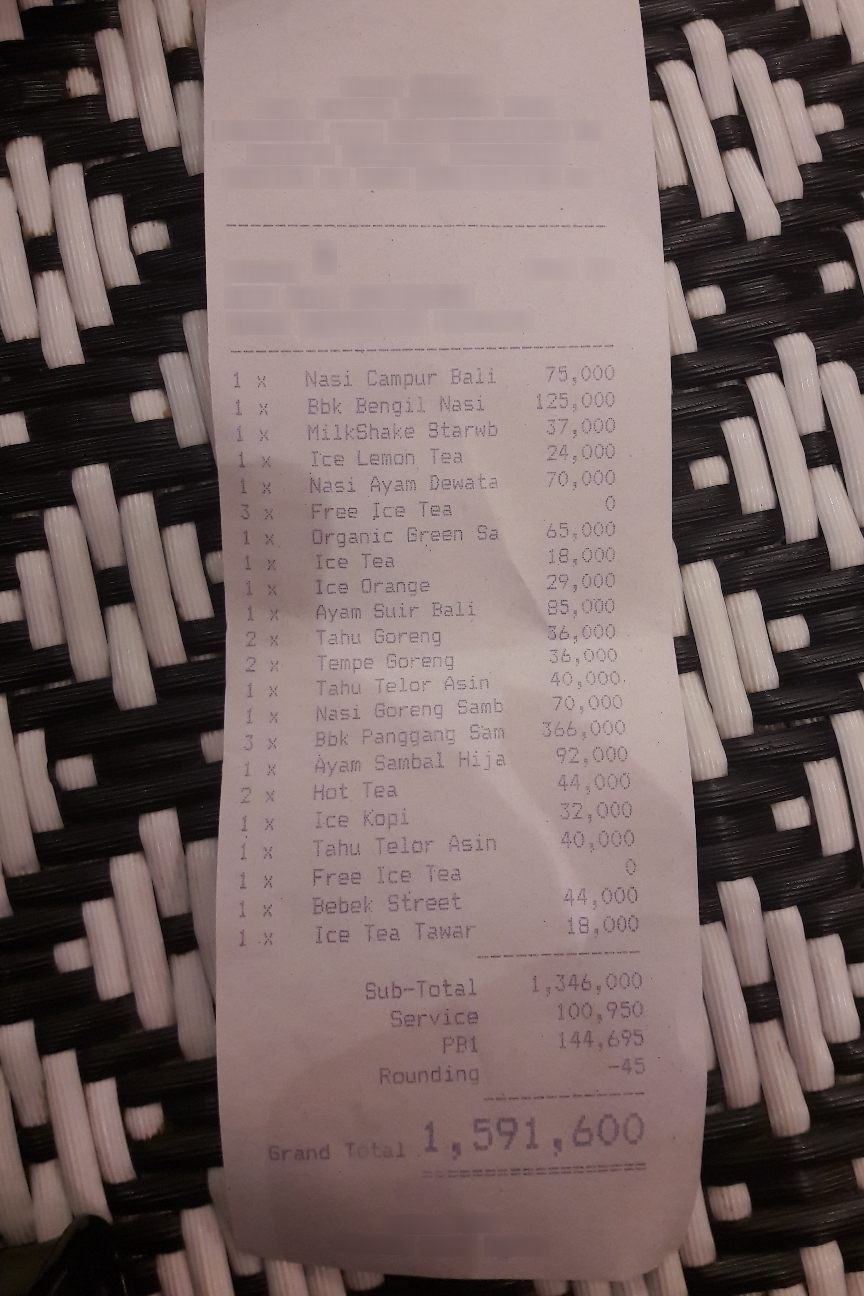

In [1]:
from pathlib import Path
from PIL import Image

path_CORD = Path.home() / "datasets/clovaai/CORD"
image_id = "00000"
image = Image.open(path_CORD / f"train/image/receipt_{image_id}.png")
image

Let's read the corresponding OCR annotations.

In [2]:
import json

with open(path_CORD / f'train/json/receipt_{image_id}.json') as json_file:
    data = json.load(json_file)

In [3]:
data.keys()

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])

In [4]:
data['dontcare']

[]

In [5]:
data['meta']

{'version': 'v0.1',
 'split': 'train',
 'image_id': 0,
 'image_size': {'width': 864, 'height': 1296}}

In [6]:
data['roi']

{}

In [7]:
data['repeating_symbol']

[]

In this particular example, the only interesting key is `valid_line` and it contains 93 OCR annotations.

In [9]:
type(data['valid_line'])

list

In [10]:
len(data['valid_line'])

93

Let's have a look at the first annotation.

In [68]:
data['valid_line'][0]

{'words': [{'quad': {'x2': 270,
    'y3': 390,
    'x3': 270,
    'y4': 390,
    'x1': 256,
    'y1': 374,
    'x4': 256,
    'y2': 374},
   'is_key': 0,
   'row_id': 2179893,
   'text': 'x'}],
 'category': 'menu.cnt',
 'group_id': 3}

So there are

- `words`
    - four coordinates of the bbox
    - a flag `is_key`
    - `row_id`
    - the `text` being detected
- a label `category`
- a `groud_id`

Let's draw the bbox along with the labels on the image.

In [13]:
import random

labels = ['menu.cnt',
 'menu.discountprice',
 'menu.etc',
 'menu.itemsubtotal',
 'menu.nm',
 'menu.num',
 'menu.price',
 'menu.sub_cnt',
 'menu.sub_etc',
 'menu.sub_nm',
 'menu.sub_price',
 'menu.sub_unitprice',
 'menu.unitprice',
 'menu.vatyn',
 'sub_total.discount_price',
 'sub_total.etc',
 'sub_total.othersvc_price',
 'sub_total.service_price',
 'sub_total.subtotal_price',
 'sub_total.tax_price',
 'total.cashprice',
 'total.changeprice',
 'total.creditcardprice',
 'total.emoneyprice',
 'total.menuqty_cnt',
 'total.menutype_cnt',
 'total.total_etc',
 'total.total_price',
 'void_menu.nm',
 'void_menu.price']

random.seed(17)
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF), range(n)))
colors = get_colors(len(labels))
print(colors)

['#d40dd3', '#9b5a53', '#bb3300', '#9449c7', '#5970be', '#8e7a42', '#386728', '#0dcaa8', '#7f703a', '#c4b213', '#d6d169', '#813871', '#a286da', '#cd9d53', '#466bd3', '#1fd7bb', '#479e92', '#64a42a', '#4d44cb', '#6b866e', '#a97d8f', '#3f3b71', '#236b5d', '#9e4f66', '#d1c0d6', '#29ea0f', '#f2bd08', '#4880bb', '#d13db9', '#ac3a48']


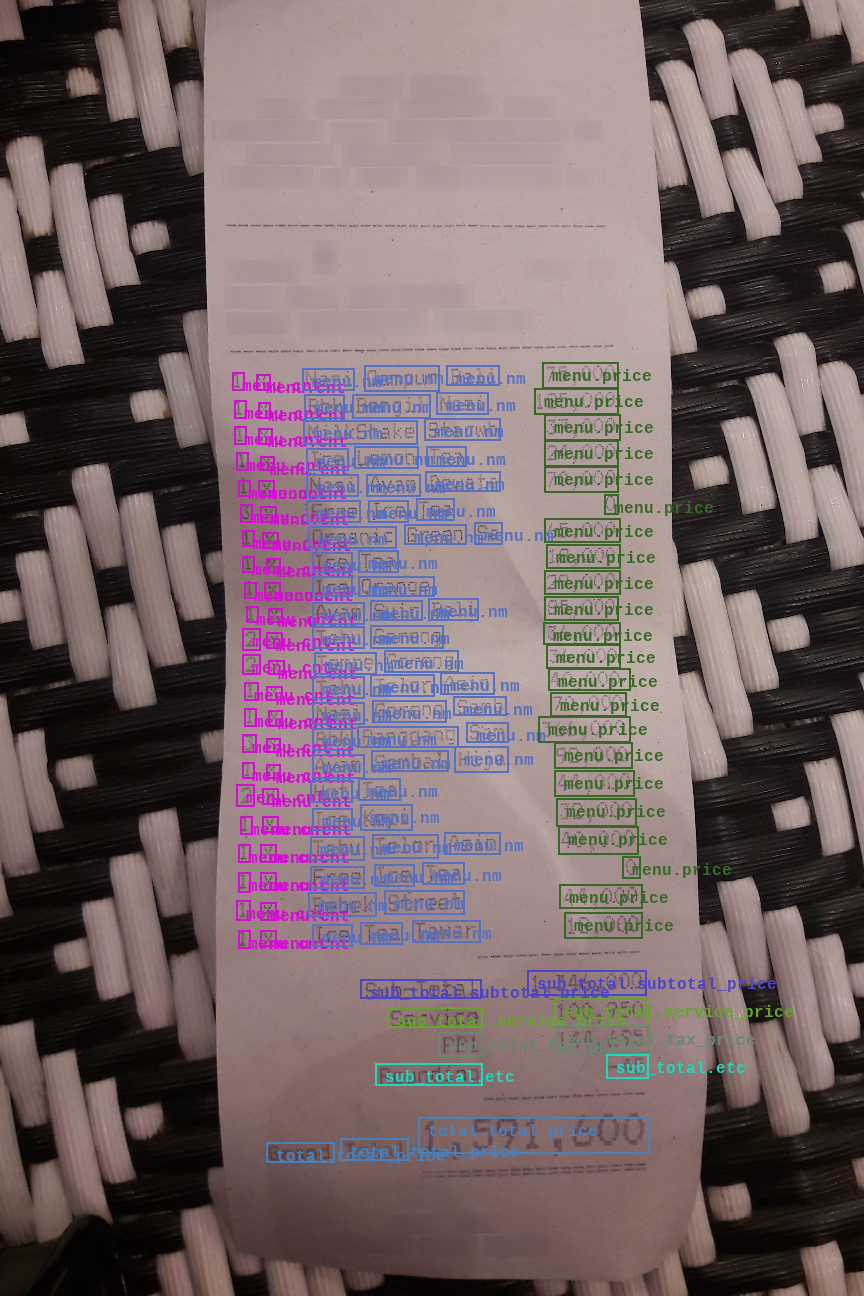

In [14]:
from PIL import ImageDraw, ImageFont

image_draw = image.copy()
draw = ImageDraw.Draw(image_draw, "RGBA")

# I have changed to a font that allows a bigger fontsize
#font = ImageFont.load_default()
font = ImageFont.truetype(
    "/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf", 16)

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
  label = annotation['category']
  words = annotation['words']
  for word in words:
    coordinates = word['quad']
    x1, y1 = coordinates['x1'], coordinates['y1']
    x3, y3 = coordinates['x3'], coordinates['y3']
    box = [x1, y1, x3, y3]
    draw.rectangle(box, outline=label2color[label], width=2)
    draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)

image_draw

So
- `menu.cnt` stands for **menu count**, i.e. the number of bought items
- `menu.nm` probably stands for **menu name**

# Generating the dataset

In [18]:
from tqdm.notebook import tqdm
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  for js in tqdm(os.listdir(path)):
    with open(path + js) as f:
        annotation_files.append(json.load(f))
  
  words = []
  boxes = []
  labels = []
  for js in tqdm(annotation_files):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      # loop over OCR annotations
      for elem in js['valid_line']:
          for word in elem['words']:
              # get word
              txt = word['text']

              # get bounding box
              # important: each bounding box should be in (upper left, lower right) format
              # it took me some time to understand the upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']
              
              box = [x1, y1, x3, y3]
              box = normalize_bbox(box, width=width, height=height)

              # ADDED
              # skip empty word
              if len(txt) < 1: 
                continue
              if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
                continue
              if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
                continue
              # ADDED

              words_example.append(txt)
              boxes_example.append(box) 
              labels_example.append(elem['category'])
      words.append(words_example) 
      boxes.append(boxes_example)
      labels.append(labels_example)
  
  return words, boxes, labels

Let's apply the function above for the training, validation and test set:

In [19]:
train_path = path_CORD / "train/json"
val_path = path_CORD / "dev/json"
test_path = path_CORD / "test/json/"
train_path.exists(), val_path.exists(), test_path.exists()

(True, True, True)

In [20]:
# can os.listdir() take as input arg a Path obj? Yes.
os.listdir(test_path)

['receipt_00043.json',
 'receipt_00014.json',
 'receipt_00038.json',
 'receipt_00002.json',
 'receipt_00080.json',
 'receipt_00063.json',
 'receipt_00055.json',
 'receipt_00075.json',
 'receipt_00019.json',
 'receipt_00096.json',
 'receipt_00022.json',
 'receipt_00074.json',
 'receipt_00034.json',
 'receipt_00081.json',
 'receipt_00059.json',
 'receipt_00078.json',
 'receipt_00015.json',
 'receipt_00062.json',
 'receipt_00058.json',
 'receipt_00097.json',
 'receipt_00035.json',
 'receipt_00023.json',
 'receipt_00003.json',
 'receipt_00018.json',
 'receipt_00039.json',
 'receipt_00049.json',
 'receipt_00008.json',
 'receipt_00065.json',
 'receipt_00042.json',
 'receipt_00004.json',
 'receipt_00072.json',
 'receipt_00024.json',
 'receipt_00032.json',
 'receipt_00053.json',
 'receipt_00048.json',
 'receipt_00033.json',
 'receipt_00069.json',
 'receipt_00073.json',
 'receipt_00045.json',
 'receipt_00025.json',
 'receipt_00012.json',
 'receipt_00088.json',
 'receipt_00028.json',
 'receipt_0

In [ ]:
words_train, boxes_train, labels_train = generate_annotations(train_path)
words_val, boxes_val, labels_val = generate_annotations(val_path)
words_test, boxes_test, labels_test = generate_annotations(test_path)

In [ ]:
labels_train[0]

['menu.nm',
 'menu.nm',
 'menu.cnt',
 'menu.price',
 'total.total_price',
 'total.total_price',
 'total.cashprice',
 'total.cashprice',
 'total.menuqty_cnt']

In [ ]:
words_train[0]

['Tebu', 'Lemon', '1', '22.000', 'Total', '22.000', 'CASH', '22.000', '1']

In [ ]:
boxes_train[0]

[[225, 563, 293, 587],
 [306, 562, 390, 587],
 [195, 564, 205, 587],
 [759, 557, 861, 584],
 [224, 623, 310, 669],
 [761, 622, 865, 670],
 [156, 707, 294, 751],
 [661, 704, 866, 755],
 [191, 625, 204, 671]]

# Saving

In [ ]:
import pickle
with open('/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/CORD_layoutlmv2_format/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train], t)
with open('/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/CORD_layoutlmv2_format/dev.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val], t)
with open('/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/CORD_layoutlmv2_format/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test], t)